# Gretel Trainer

This notebook is designed to help users successfully train synthetic models on complex datasets with high row and column counts. The code works by intelligently dividing a dataset into a set of smaller datasets of correlated columns that can be parallelized and then joined together. 

**Getting started:**


*   Copy your [Gretel API](https://console.gretel.cloud) key to the clipboard.
*   Update the `DATASET_PATH` to your dataset, or use the provided example.
*   Click Runtime -> Run All.
*   Use the correlation graph to compare your real world and synthetic data! 



In [ ]:
import os

!git clone https://github.com/gretelai/trainer.git

os.chdir('./trainer')
!pip install .

In [ ]:
!pip install plotly

In [1]:
from getpass import getpass
from functools import lru_cache
import pandas as pd

from trainer import strategy, runner

from gretel_client import configure_session, ClientConfig
from gretel_client.projects import create_or_get_unique_project
from gretel_client.projects.models import read_model_config
from gretel_client.projects.jobs import Status
from gretel_synthetics.utils.header_clusters import cluster

In [2]:
# Only enter API once per Notebook session
@lru_cache()
def get_api_key(target: str) -> str:
    api_key = getpass(prompt="Enter Gretel API key")
    return api_key

In [3]:
# Specify your Gretel API key    
configure_session(ClientConfig(api_key=get_api_key("key"), endpoint="https://api.gretel.cloud"))

Enter Gretel API key········


## Project Settings

Use the configuration options below to control parallelization settings.
* `MAX_ROWS` sets the maximum number of rows per sub-model, which helps reduce per-job run time and the need to tune neural network parameters such as `learning_rate`, `batch_size`, and `rnn_units` for larger datasets. Typical values are 20,000-100,000 rows.
* `MAX_HEADER_CLUSTERS` sets the maximum number of columns to include for each sub-model. Higher values help with maintaining complex correlations in datasets. Try a lower value if you have mixed text and numeric values, or if the model is not generating valid records. Typical values are 10-20 columns.

In [5]:
MAX_ROWS = 20000 # Maximum row count per model
MAX_HEADER_CLUSTERS = 20 # Max columns per cluster
PROJECT_NAME = 'health-data-2'
PROJECT = create_or_get_unique_project(name=PROJECT_NAME)
CACHE_FILE = "runner.json"

print(f"Follow model training at: {PROJECT.get_console_url()}")

Follow model training at: https://console.gretel.cloud/health-data-2-ff62139634


## Dataset Preprocessing

Preprocess the data before training the network. A few tips:
* Try reducing floating point precision to a consistent number of decimal places (default: 4)
* Fields containing complex random numbers (such as UIDs) can be difficult for language models to learn. Try dropping them, specifying them as model seeds to preserve them, or replacing them with a LabelEncoder.

In [7]:
DATASET_PATH = '../data/mitre-synthea-health.csv'
ROUND_DECIMALS = 4


def preprocess_data(dataset_path: str) -> pd.DataFrame:
    tmp = pd.read_csv(dataset_path, low_memory=False)
    tmp = tmp.round(ROUND_DECIMALS)
    return tmp


DF = preprocess_data(DATASET_PATH)
DF

,EventDate,DATE,PatientID,BirthDate,DeathDate,RACE,ETHNICITY,GENDER,BIRTHPLACE,ADDRESS,...,EncounterReason,EncounterReasonDesc,ObsCode,ObsDesc,ObsValue,ObsValueFloat,UNITS,ProcedureDate,ProcedureDesc,ProcedureReason
0,2013-06-07,2013-07-01,d091c3eb,1937-03-02,1900-01-01,white,french,M,MA US,01202 US,...,NaN,NaN,6298-4,Potassium,6.5074,6.5074,mmol/L,2016-03-03,Documentation of current medications,NaN
1,2011-01-28,2010-12-16,0bdda8d2,1984-06-11,1900-01-01,black,african,F,MA US,01910 US,...,NaN,NaN,6298-4,Potassium,6.5325,6.5325,mmol/L,2014-03-02,Intramuscular injection,NaN
2,2016-09-06,2016-10-03,f0577b5f,1977-08-24,1900-01-01,white,english,M,MA US,02140 US,...,NaN,NaN,6298-4,Potassium,6.5200,6.5200,mmol/L,2012-08-31,Biopsy of colon,68496003.0
3,2012-05-05,2012-04-26,a9fb85a6,1954-03-14,1900-01-01,white,french,M,MA US,01202 US,...,NaN,NaN,6298-4,Potassium,6.5074,6.5074,mmol/L,2012-04-28,Documentation of current medications,NaN
4,2011-01-28,2010-12-16,0bdda8d2,1984-06-11,1900-01-01,white,german,M,MA US,01853 US,...,10509002.0,Acute bronchitis (disorder),6298-4,Potassium,6.5200,6.5200,mmol/L,2011-02-04,Documentation of current medications,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2280,2013-06-20,2013-07-16,a4a433e9,1941-11-06,1900-01-01,hispanic,mexican,M,MA US,01813 US,...,NaN,NaN,6298-4,Potassium,6.5074,6.5074,mmol/L,2014-06-04,Colonoscopy,NaN
2281,2013-07-09,2013-06-03,17f227c5,1940-07-04,1900-01-01,hispanic,mexican,F,MA US,02211 US,...,444814009.0,Viral sinusitis (disorder),6298-4,Potassium,6.5074,6.5074,mmol/L,2013-02-13,Documentation of current medications,NaN
2282,2017-08-12,2017-05-19,7ce419ba,1944-08-07,1900-01-01,white,french,M,MA US,01202 US,...,NaN,NaN,6298-4,Potassium,6.5074,6.5074,mmol/L,2013-05-02,Documentation of current medications,NaN
2283,2016-12-03,2016-12-07,a9c0db54,1974-12-09,1900-01-01,white,swedish,F,MA US,01844 US,...,NaN,NaN,6298-4,Potassium,6.5325,6.5325,mmol/L,2015-05-23,Documentation of current medications,NaN


In [8]:
SEED_FIELDS = ["RACE", "ETHNICITY", "GENDER"]

## Hyperparameter Settings

View example default configs on GitHub https://github.com/gretelai/gretel-blueprints/tree/main/config_templates/gretel/synthetics. A few tips:

* For larger dataset sizes (50,000-100,000 rows) try setting `vocab_size` to 20,000. This uses a `sentencepiece` tokenizer and will speed up model training and generation. For smaller datasets or if you're seeing high invalid record counts, use `vocab_size` of 0 to tokenize per character.

In [9]:
# Fine tune any configuration settings here

CONFIG = read_model_config("synthetics/default")
CONFIG["models"][0]["synthetics"]["params"]["vocab_size"] = 0
CONFIG["models"][0]["synthetics"]["params"]["learning_rate"] = 0.001
CONFIG["models"][0]["synthetics"]["privacy_filters"] = {}
CONFIG["models"][0]["synthetics"]["privacy_filters"]["outliers"] = None
CONFIG["models"][0]["synthetics"]["privacy_filters"]["similarity"] = None

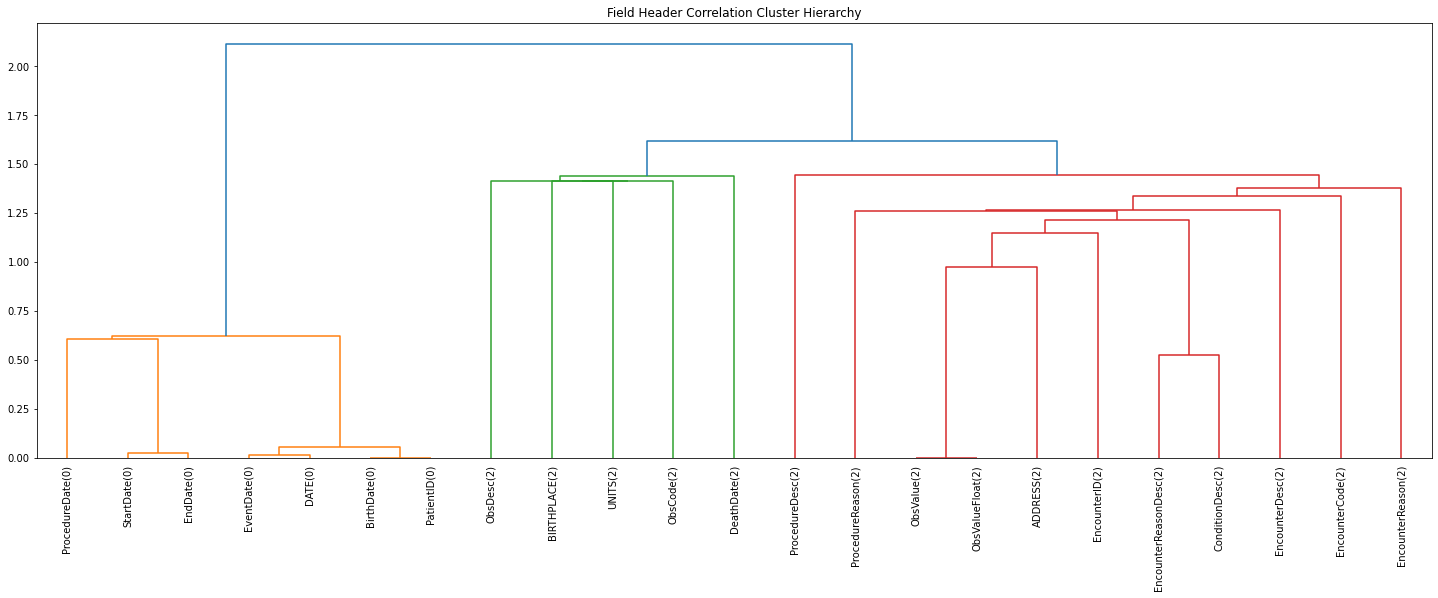

In [10]:
# Initialize the parallelization strategy

def initialize_run() -> runner.StrategyRunner:
    
    # Create clusters of correlated columns (might take a few minutes)
    plot = True if len(DF.columns) < 50 else False
    header_clusters = cluster(DF, header_prefix=SEED_FIELDS, maxsize=MAX_HEADER_CLUSTERS, plot=plot) 

    constraints = strategy.PartitionConstraints(
        header_clusters=header_clusters, 
        max_row_count=MAX_ROWS,
        seed_headers=SEED_FIELDS
    )
    
    run = runner.StrategyRunner(
        strategy_id="foo",
        df=DF,
        cache_file=CACHE_FILE,
        cache_overwrite=True,  # Set to False to load existing cache (and not start over)
        model_config=CONFIG,
        partition_constraints=constraints,
        project=PROJECT
    )    
    return run

run = initialize_run()

In [ ]:
# Train all models
run.train_all_partitions()

INFO:trainer.runner:Processing 2 partitions
INFO:trainer.runner:Partition 0 is new, starting model creation
INFO:trainer.runner:Started model: rambunctious-whimsical-dinasaur source: ['gretel_d988466cb7cc4ee4a59fae10c55c0b3d_foo-0.csv']
INFO:trainer.runner:Partition 0 status change from created to pending
INFO:trainer.runner:Partition 1 is new, starting model creation
INFO:trainer.runner:Started model: astonishing-daffy-dog source: ['gretel_8b83124b08084cc0a9dd2293c869b85d_foo-1.csv']
INFO:trainer.runner:Partition 0 status change from pending to active
INFO:trainer.runner:Partition 1 status change from created to pending
INFO:trainer.runner:Partition 1 status change from pending to active


In [ ]:
# Access synthetic data

synthetic = run.get_training_synthetic_data()
synthetic.to_csv('synthetic.csv', index=False)
synthetic

In [ ]:
#Uncomment and run these lines to terminate models training in the cloud

#run.cancel_all()
#PROJECT.delete()

## Plot correlations

Use the `_get_correlation_matrix` from `gretel-synthetics` to compare correlations between the real world and synthetic datasets.

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from gretel_synthetics.utils.header_clusters import _get_correlation_matrix


def plot_correlations(real_df: pd.DataFrame, synthetic_df: pd.DataFrame):
    s_corr = _get_correlation_matrix(real_df)
    r_corr = _get_correlation_matrix(synthetic_df)

    fig = make_subplots(rows=1, cols=2, horizontal_spacing=0.2)
    fig.update_layout(title_text="Real world vs. Synthetic Correlations")
    trace1 = go.Heatmap(z=r_corr, y=r_corr.index, x=r_corr.columns)
    trace2 = go.Heatmap(z=s_corr, y=s_corr.index, x=s_corr.columns)
    fig.add_trace(trace1, row=1, col=1)
    fig.add_trace(trace2, row=1, col=2)
    fig.update_traces(showscale=False)
    fig.show()

plot_correlations(DF, synthetic)

# Load and generate data from a Strategy

In [ ]:
run = runner.StrategyRunner(
    strategy_id="foo",
    df=None,
    cache_file=CACHE_FILE,
    cache_overwrite=False,  # Set to False to load existing cache (and not start over)
    model_config=None,
    partition_constraints=None,
    project=PROJECT
) 

In [ ]:
run.generate_data(num_records=500, max_invalid=None)

In [ ]:
run.get_synthetic_data()

In [ ]:
# Let's generate a new batch of Synthetic data, but utilize our seed fields

# NOTE: Specify the values you want to use as seeds in the *same* order you defined the seed headers

seed_df = pd.DataFrame(data=[
    ["black", "african", "F"],
    ["black", "african", "F"],
    ["black", "african", "F"],
    ["black", "african", "F"],
    ["asian", "chinese", "F"],
    ["asian", "chinese", "F"],
    ["asian", "chinese", "F"],
    ["asian", "chinese", "F"],
    ["asian", "chinese", "F"]
], columns=["RACE", "ETHNICITY", "GENDER"])

In [ ]:
run.generate_data(seed_df=seed_df)

In [ ]:
run.get_synthetic_data()